In [1]:
import numpy as np
import os
import json
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
import pandas as pd
# import Patch


import sys
sys.path.append('../../')

In [2]:
def read_npz_files_in_s_folders(directory):
    data_files = {}
    for item in os.scandir(directory):
        if item.is_dir() and item.name.endswith(''):
            npz_path = os.path.join(item.path, 'data.npz')
            if os.path.exists(npz_path):
                data = np.load(npz_path)
                data_files[item.name] = data
    
    return data_files

In [3]:
# Example usage
data_files = read_npz_files_in_s_folders('./data')
print(data_files.keys())

dict_keys(['iEKF', 'PLF', 'GGF_weight8', 'GGF_beta1e-2', 'UKF', 'GGF_weight5', 'GGF_beta2e-2', 'GGF_huber3', 'GGF_weight10', 'GGF_huber1', 'GGF', 'GGF_huber2', 'EKF', 'GGF_beta5e-3'])


In [4]:
pos_gt = data_files['EKF']['x_mc'][:, :, :2]
pos_ekf = data_files['EKF']['x_hat_mc'][:, :, :2]
pos_ukf = data_files['UKF']['x_hat_mc'][:, :, :2]
pos_iekf = data_files['iEKF']['x_hat_mc'][:, :, :2]
pos_plf = data_files['PLF']['x_hat_mc'][:, :, :2]
pos_nano = data_files['GGF']['x_hat_mc'][:, :, :2]
pos_wnano = data_files['GGF_weight5']['x_hat_mc'][:, :, :2]
pos_hnano = data_files['GGF_huber1']['x_hat_mc'][:, :, :2]
pos_bnano = data_files['GGF_beta2e-2']['x_hat_mc'][:, :, :2]

In [23]:
import matplotlib as mpl
def plot(true_trajectory, ukf_trajectory, mhe_trajectory, robust_mhe_trajectory, save_path):
    # 设置字体为 serif
    mpl.rcParams['font.family'] = 'serif'
    mpl.rcParams['font.size'] = 15

    # 计算误差方差
    error_ukf = np.sqrt(np.sum((true_trajectory - ukf_trajectory) ** 2, axis=2))
    error_mhe = np.sqrt(np.sum((true_trajectory - mhe_trajectory) ** 2, axis=2))
    error_robust_mhe = np.sqrt(np.sum((true_trajectory - robust_mhe_trajectory) ** 2, axis=2))

    print(error_ukf.shape)

    # 计算每个轨迹的平均值
    mean_true = np.mean(true_trajectory, axis=0)
    mean_ukf = np.mean(ukf_trajectory, axis=0)
    mean_mhe = np.mean(mhe_trajectory, axis=0)
    mean_robust_mhe = np.mean(robust_mhe_trajectory, axis=0)

    # 创建一个新的绘图
    plt.figure()

    # 绘制每个轨迹的平均值，颜色由误差方差确定
    plt.scatter(mean_true[:, 0], mean_true[:, 1], c='blue', marker='o', label='True trajectory')
    plt.scatter(mean_ukf[:, 0], mean_ukf[:, 1], c=np.mean(error_ukf, axis=0), marker='+', cmap='Greens', label='EKF', edgecolors='face', vmin=0, vmax=np.percentile(error_ukf, 75))
    plt.scatter(mean_mhe[:, 0], mean_mhe[:, 1], c=np.mean(error_mhe, axis=0), marker='+', cmap='Purples', label='NANO', edgecolors='face', vmin=0, vmax=np.percentile(error_mhe, 75))
    plt.scatter(mean_robust_mhe[:, 0], mean_robust_mhe[:, 1], c=np.mean(error_robust_mhe, axis=0), marker='+', cmap='Reds', label=r'$\beta$'+'-NANO', edgecolors='face', vmin=0, vmax=np.percentile(error_robust_mhe, 75))

    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    # plt.title('Robot Trajectories with Estimation Error Variance')

    # 添加一个颜色条
    sm = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=0, vmax=max(np.max(error_ukf), np.max(error_mhe), np.max(error_robust_mhe))))
    sm.set_array([])
    cbar = plt.colorbar(sm, label='Estimation Error Variance')

    # 添加图例
    max_ukf_error = np.percentile(error_ukf, 75)
    max_mhe_error = np.percentile(error_mhe, 75)
    max_robust_mhe_error = np.percentile(error_robust_mhe, 75)

    # 创建代表颜色的列表
    ukf_legend_color = plt.cm.Greens(max_ukf_error / np.percentile(error_ukf, 75))
    mhe_legend_color = plt.cm.Purples(max_mhe_error / np.percentile(error_mhe, 75))
    robust_mhe_legend_color = plt.cm.Reds(max_robust_mhe_error / np.percentile(error_robust_mhe, 75))

    # 创建图例条目
    true_patch = mpl.lines.Line2D([], [], color='blue', marker='o', markersize=5, label='True trajectory')
    ukf_patch = mpl.lines.Line2D([], [], color=ukf_legend_color, marker='+', markersize=5, label='UKF')
    mhe_patch = mpl.lines.Line2D([], [], color=mhe_legend_color, marker='+', markersize=5, label='MHE')
    robust_mhe_patch = mpl.lines.Line2D([], [], color=robust_mhe_legend_color, marker='+', markersize=5, label='βMHE')

    # 添加图例到图中
    plt.legend(handles=[true_patch, ukf_patch, mhe_patch, robust_mhe_patch])

    plt.grid()

    # 保存图像为 PDF
    plt.savefig(save_path, format='pdf', bbox_inches='tight', dpi=300)
    plt.show()

/tmp/ipykernel_120355/3384602056.py:23: UserWarning: You passed a edgecolor/edgecolors ('face') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(mean_ukf[:, 0], mean_ukf[:, 1], c=np.mean(error_ukf, axis=0), marker='+', cmap='Greens', label='EKF', edgecolors='face', vmin=0, vmax=np.percentile(error_ukf, 75))
/tmp/ipykernel_120355/3384602056.py:24: UserWarning: You passed a edgecolor/edgecolors ('face') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(mean_mhe[:, 0], mean_mhe[:, 1], c=np.mean(error_mhe, axis=0), marker='+', cmap='Purples', label='NANO', edgecolors='face', vmin=0, vmax=np.percentile(error_mhe, 75))
/tmp/ipykernel_120355/3384602056.py:25: UserWarning: You passed a edgecolor/edgecolors ('face') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of th

ValueError: Unable to determine Axes to steal space for Colorbar. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.

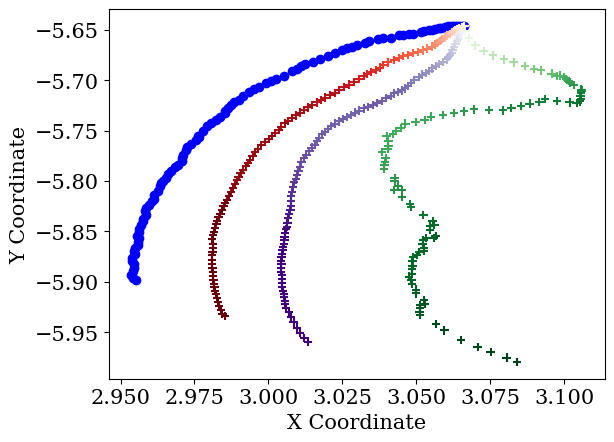

In [26]:
plot(pos_gt, pos_ekf, pos_nano, pos_bnano, save_path='./figs/robot_trajectories.pdf')

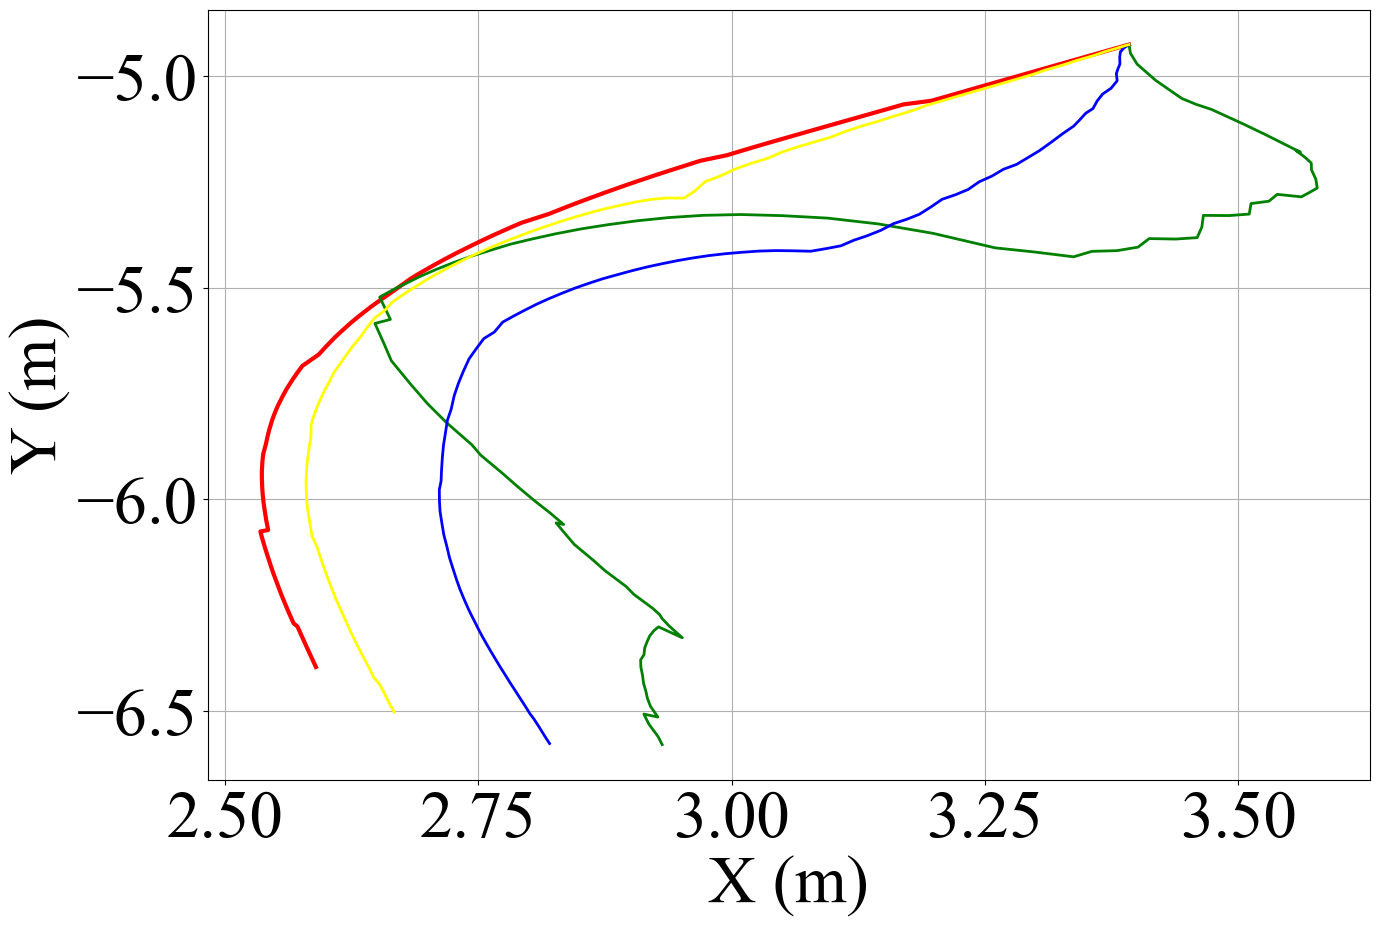

In [22]:
import matplotlib.pyplot as plt
import numpy as np
# 设置字体和样式
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['mathtext.rm'] = 'Times New Roman'
plt.rcParams['font.size'] = 48

colors = ['red']+['green']+['blue']+['yellow']
label = ['Ground Truth', 'EKF', 'NANO', r'$\beta$'+'-NANO']

# 使用第几条轨迹（可选1-46）
n=40

# 创建一个图形和轴
plt.figure(figsize=(15, 10))

# 绘制真实值的轨迹
plt.plot(pos_gt[n, :, 0], pos_gt[n, :, 1], label='Ground Truth', color=colors[0], linewidth=3)

# 绘制预测值的轨迹
plt.plot(pos_ekf[n, :, 0], pos_ekf[n, :, 1], label='EKF', color=colors[1],linewidth=2)
plt.plot(pos_nano[n, :, 0], pos_nano[n, :, 1], label='NANO', color=colors[2],linewidth=2)
plt.plot(pos_bnano[n, :, 0], pos_bnano[n, :, 1], label=r'$\beta$'+'-NANO', color=colors[3],linewidth=2)

# 添加标题和轴标签
# plt.title('Robot Trajectory')
plt.xlabel('X (m)')
plt.ylabel('Y (m)')

# 显示网格
plt.grid(True)

# plt.legend()

plt.savefig(f'./figs/traj{n}.pdf', bbox_inches='tight')

# 显示图形
plt.show()

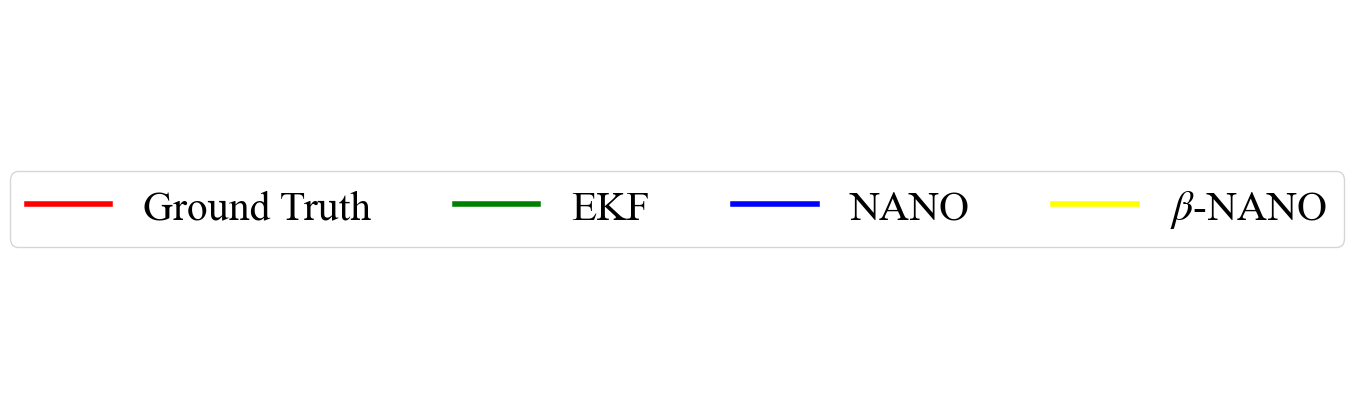

In [21]:
from matplotlib.lines import Line2D
linestyle = '-'
# legend_elements = [Patch(facecolor=colors[i], label=label[i]) for i in range(len(label))]
legend_elements = [Line2D([0], [0], color=colors[i], lw=4, linestyle=linestyle, label=label[i]) for i in range(len(label))]
f2 = plt.figure(figsize=(8, 4), dpi=100)
ax2 = f2.add_axes([0, 0, 1, 1])
ax2.legend(handles=legend_elements, loc='center', fontsize=30, ncol=4)
ax2.axis('off')
plt.savefig('./figs/ugv_legend.pdf', bbox_inches='tight')

3.5777052009029746


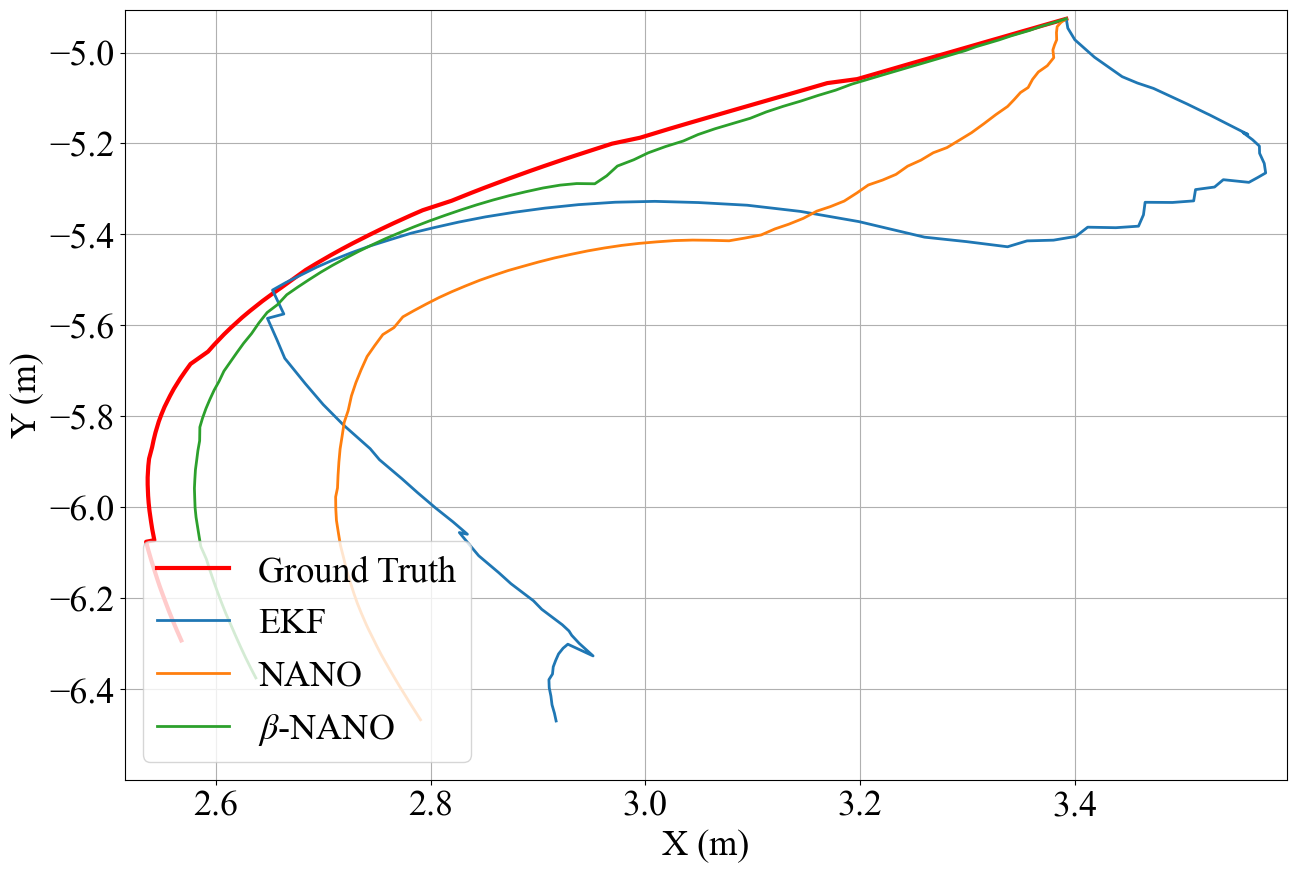

In [32]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.animation import FuncAnimation

# 设置字体和样式
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['mathtext.rm'] = 'Times New Roman'
plt.rcParams['font.size'] = 26

# 创建一个图形和轴
fig, ax = plt.subplots(figsize=(15, 10))

# 设置坐标轴标签
ax.set_xlabel('X (m)')
ax.set_ylabel('Y (m)')

# 显示网格
ax.grid(True)

# 绘制初始的空轨迹线
line_gt, = ax.plot([], [], label='Ground Truth', color='red', linewidth=3)
line_ekf, = ax.plot([], [], label='EKF', linewidth=2)
line_nano, = ax.plot([], [], label='NANO', linewidth=2)
line_bnano, = ax.plot([], [], label=r'$\beta$'+'-NANO', linewidth=2)

# 设置图例
ax.legend(loc='lower left')

# 使用第几条轨迹（可选1-46）
n=40

# 设定绘图范围，使得所有轨迹都能显示在图中
x_min = min(np.min(pos_gt[n, :, 0]), np.min(pos_ekf[n, :, 0]), np.min(pos_nano[n, :, 0]), np.min(pos_bnano[n, :, 0]))
x_max = max(np.max(pos_gt[n, :, 0]), np.max(pos_ekf[n, :, 0]), np.max(pos_nano[n, :, 0]), np.max(pos_bnano[n, :, 0]))
y_min = min(np.min(pos_gt[n, :, 1]), np.min(pos_ekf[n, :, 1]), np.min(pos_nano[n, :, 1]), np.min(pos_bnano[n, :, 1]))
y_max = max(np.max(pos_gt[n, :, 1]), np.max(pos_ekf[n, :, 1]), np.max(pos_nano[n, :, 1]), np.max(pos_bnano[n, :, 1]))

print(x_max)
# 设置坐标轴的范围
ax.set_xlim(x_min-0.02, x_max+0.02)
ax.set_ylim(y_min-0.02, y_max+0.02)


# 间隔采样，减少帧数，避免卡顿
step_size = 5  # 每隔5个数据点绘制一次
frames = len(pos_gt[0]) // step_size

# 更新每一帧的数据
def update(frame):
    idx = frame * step_size
    line_gt.set_data(pos_gt[n, :idx, 0], pos_gt[n, :idx, 1])
    line_ekf.set_data(pos_ekf[n, :idx, 0], pos_ekf[n, :idx, 1])
    line_nano.set_data(pos_nano[n, :idx, 0], pos_nano[n, :idx, 1])
    line_bnano.set_data(pos_bnano[n, :idx, 0], pos_bnano[n, :idx, 1])
    return line_gt, line_ekf, line_nano, line_bnano

# 创建动画，interval表示帧与帧之间的时间间隔
ani = FuncAnimation(fig, update, frames=frames, interval=200, blit=False)

# 保存动图为 gif 文件
ani.save(f'./gif/traj{n}.gif', writer='pillow')

# 显示动图
plt.show()